In [26]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split


from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

import jieba as jb
import re

In [107]:
df = pd.read_csv('./sp_itp_207208789/sg_date_2000_2012.csv')
df=df[['month','street_name','flat_model','resale_price']]
print("total: %d ." % len(df))
df.sample(30)

total: 369651 .


,month,street_name,flat_model,resale_price
195643,2007/3/1,JURONG WEST ST 61,Model A,225000.0
108910,2010/12/1,TECK WHYE LANE,Improved,346000.0
271748,2004/5/1,ANG MO KIO AVE 10,New Generation,156000.0
288900,2007/6/1,BEDOK NTH ST 3,New Generation,151000.0
77685,2007/5/1,TELOK BLANGAH DR,Improved,176000.0
110978,2011/3/1,WOODLANDS RING RD,Improved,385000.0
70753,2006/5/1,KIM KEAT AVE,Improved,145000.0
325719,2010/3/1,EDGEDALE PLAINS,Premium Apartment,318000.0
230677,2011/10/1,TAMPINES ST 72,Model A,478000.0
79734,2007/8/1,CHOA CHU KANG ST 51,Improved,278000.0


In [108]:
print("in street_name have %d null." % df['street_name'].isnull().sum())
print("in flat_model have %d null." % df['flat_model'].isnull().sum())
print("in resale_price have %d null." % df['resale_price'].isnull().sum())
df[df.isnull().values==True]
df = df[pd.notnull(df['resale_price'])]

in street_name have 0 null.
in flat_model have 0 null.
in resale_price have 0 null.


In [109]:
d = {'flat_model':df['flat_model'].value_counts().index, 'count': df['flat_model'].value_counts()}
df_cat = pd.DataFrame(data=d).reset_index(drop=True)
df_cat

,flat_model,count
0,Model A,106147
1,Improved,100441
2,New Generation,71685
3,Simplified,22370
4,Premium Apartment,18300
5,Standard,16894
6,Apartment,15274
7,Maisonette,9839
8,Model A2,6696
9,Adjoined flat,799


Text(0.5, 0, 'type name')

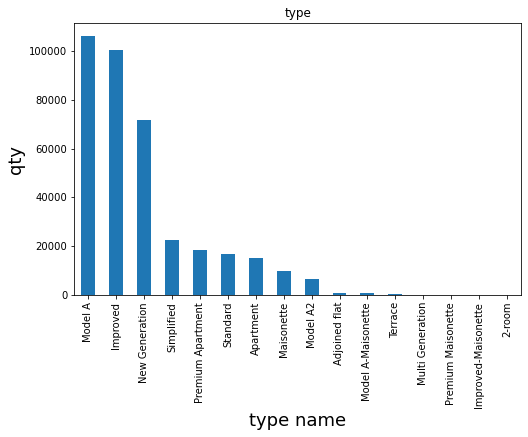

In [110]:
df_cat.plot(x='flat_model', y='count', kind='bar', legend=False,  figsize=(8, 5))
plt.title("type")
plt.ylabel('qty', fontsize=18)
plt.xlabel('type name', fontsize=18)

In [111]:
df['type_id'] = df['flat_model'].factorize()[0]
cat_id_df = df[['flat_model', 'type_id']].drop_duplicates().sort_values('type_id').reset_index(drop=True)
cat_to_id = dict(cat_id_df.values)
id_to_cat = dict(cat_id_df[['type_id', 'flat_model']].values)
df.sample(10)

,month,street_name,flat_model,resale_price,type_id
210804,2009/4/1,YISHUN CTRL,Model A,308000.0,6
36829,2002/3/1,BOON LAY PL,Improved,89000.0,3
337881,2003/3/1,BT BATOK ST 32,Simplified,106100.0,13
59940,2005/1/1,HOUGANG AVE 8,Improved,300000.0,3
192959,2006/10/1,YISHUN CTRL,Model A,224000.0,6
128619,2000/4/1,BT BATOK ST 34,Model A,258000.0,6
9156,2006/6/1,HOUGANG ST 91,Apartment,358000.0,2
265706,2003/6/1,ANG MO KIO AVE 10,New Generation,154000.0,10
82449,2007/12/1,GANGSA RD,Improved,315000.0,3
142913,2001/7/1,PENDING RD,Model A,131300.0,6


In [112]:
#datetime_format = new_dt.strftime("%Y-%m-%d %H:%M:%S")
#date_time_obj = datetime.datetime.strptime(df["month"], '%Y-%m-%d')
df['month'] = pd.to_datetime(df['month'], format='%Y-%m-%d')
df.sample(10)

,month,street_name,flat_model,resale_price,type_id
215689,2009-11-01,WOODLANDS CIRCLE,Model A,310000.0,6
297166,2009-03-01,TEBAN GDNS RD,New Generation,268000.0,10
87362,2008-07-01,WOODLANDS ST 41,Improved,331000.0,3
85213,2008-04-01,SEMBAWANG DR,Improved,335000.0,3
292521,2008-03-01,JURONG WEST ST 52,New Generation,175000.0,10
287805,2007-03-01,TECK WHYE LANE,New Generation,177000.0,10
148986,2001-12-01,WOODLANDS DR 72,Model A,208000.0,6
351210,2011-02-01,YISHUN ST 22,Simplified,282000.0,13
330055,2002-07-01,CHOA CHU KANG NTH 6,Premium Maisonette,625000.0,12
275532,2004-12-01,TAMPINES ST 21,New Generation,219000.0,10


In [128]:
t1 = df[df["flat_model"] == "Improved"]
t1.sample(30)

,month,street_name,flat_model,resale_price,type_id
112177,2011-06-01,CHAI CHEE RD,Improved,573000.0,3
66400,2005-10-01,WOODLANDS CRES,Improved,245000.0,3
103679,2010-06-01,SIN MING RD,Improved,243000.0,3
59526,2004-12-01,SERANGOON NTH AVE 2,Improved,263000.0,3
37521,2002-04-01,TG PAGAR PLAZA,Improved,185000.0,3
106470,2010-08-01,WOODLANDS ST 83,Improved,380000.0,3
81098,2007-10-01,JLN RUMAH TINGGI,Improved,525000.0,3
26924,2001-04-01,BEDOK RESERVOIR RD,Improved,144000.0,3
17561,2000-03-01,ELIAS RD,Improved,400000.0,3
48191,2003-07-01,JLN RUMAH TINGGI,Improved,465000.0,3


In [126]:
t2=t1.reset_index()['resale_price']
t2

0         147000.0
1         144000.0
2         408000.0
3         375000.0
4         380000.0
            ...   
100436    465000.0
100437    503000.0
100438    476888.0
100439    490000.0
100440    488000.0
Name: resale_price, Length: 100441, dtype: float64

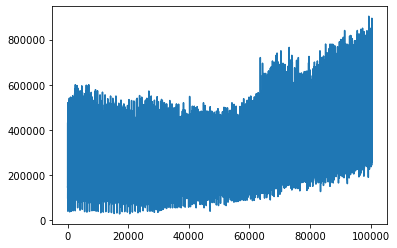

In [129]:
plt.plot(t2)

In [130]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
t3=scaler.fit_transform(np.array(t2).reshape(-1,1))

In [131]:
print(t3)

[[0.136     ]
 [0.13257143]
 [0.43428571]
 ...
 [0.51301486]
 [0.528     ]
 [0.52571429]]


In [134]:
##splitting dataset into train and test split
training_size=int(len(t3)*0.7)
test_size=len(t3)-training_size
train_data,test_data=t3[0:training_size,:],t3[training_size:len(t3),:1]

In [135]:
training_size,test_size

(70308, 30133)

In [136]:
train_data

array([[0.136     ],
       [0.13257143],
       [0.43428571],
       ...,
       [0.33942857],
       [0.35657143],
       [0.336     ]])

In [139]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [140]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [141]:
print(X_train.shape), print(y_train.shape)

(70207, 100)
(70207,)


(None, None)

In [142]:
print(X_test.shape), print(ytest.shape)

(30032, 100)
(30032,)


(None, None)

In [143]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [145]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [144]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [146]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [147]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
1097/1097 [==============================] - 112s 102ms/step - loss: 0.0059 - val_loss: 0.0064
Epoch 2/100
1097/1097 [==============================] - 121s 110ms/step - loss: 0.0041 - val_loss: 0.0075
Epoch 3/100
1097/1097 [==============================] - 105s 96ms/step - loss: 0.0040 - val_loss: 0.0066
Epoch 4/100
1097/1097 [==============================] - 100s 91ms/step - loss: 0.0040 - val_loss: 0.0072
Epoch 5/100
1097/1097 [==============================] - 103s 94ms/step - loss: 0.0040 - val_loss: 0.0072
Epoch 6/100
1097/1097 [==============================] - 101s 92ms/step - loss: 0.0040 - val_loss: 0.0071
Epoch 7/100
1097/1097 [==============================] - 97s 89ms/step - loss: 0.0040 - val_loss: 0.0084
Epoch 8/100
1097/1097 [==============================] - 99s 90ms/step - loss: 0.0040 - val_loss: 0.0070
Epoch 9/100
1097/1097 [==============================] - 98s 89ms/step - loss: 0.0040 - val_loss: 0.0076
Epoch 10/100
1097/1097 [=======================

1097/1097 [==============================] - 96s 87ms/step - loss: 0.0029 - val_loss: 0.0158
Epoch 79/100
1097/1097 [==============================] - 96s 88ms/step - loss: 0.0029 - val_loss: 0.0176
Epoch 80/100
1097/1097 [==============================] - 96s 88ms/step - loss: 0.0029 - val_loss: 0.0173
Epoch 81/100
1097/1097 [==============================] - 95s 87ms/step - loss: 0.0028 - val_loss: 0.0195
Epoch 82/100
1097/1097 [==============================] - 95s 87ms/step - loss: 0.0028 - val_loss: 0.0186
Epoch 83/100
1097/1097 [==============================] - 96s 87ms/step - loss: 0.0028 - val_loss: 0.0195
Epoch 84/100
1097/1097 [==============================] - 95s 87ms/step - loss: 0.0028 - val_loss: 0.0219
Epoch 85/100
1097/1097 [==============================] - 95s 86ms/step - loss: 0.0027 - val_loss: 0.0189
Epoch 86/100
1097/1097 [==============================] - 95s 86ms/step - loss: 0.0027 - val_loss: 0.0196
Epoch 87/100
1097/1097 [==============================] - 9

In [148]:
import tensorflow as tf

In [149]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [150]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [151]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

272715.2161951097

In [152]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

353787.78420636413

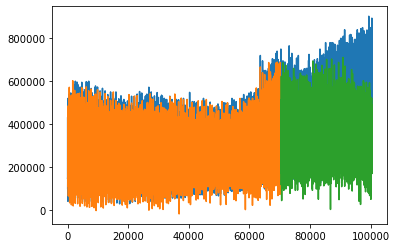

In [154]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(t3)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(t3)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(t3)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(t3))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [155]:
len(test_data)

30133

In [160]:
x_input=test_data[29133:].reshape(1,-1)
x_input.shape

(1, 1000)

In [161]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [163]:
temp_input

[0.6137142857142857,
 0.5394285714285714,
 0.5651428571428571,
 0.5108571428571428,
 0.5335862857142857,
 0.5257142857142857,
 0.5851428571428571,
 0.5542857142857143,
 0.5314285714285714,
 0.5394285714285714,
 0.5565714285714285,
 0.5222857142857142,
 0.5622857142857142,
 0.5279999999999999,
 0.5165714285714285,
 0.5165714285714285,
 0.47657142857142853,
 0.5222857142857142,
 0.5051428571428571,
 0.568,
 0.5965714285714285,
 0.5131428571428571,
 0.368,
 0.368,
 0.6537142857142856,
 0.688,
 0.6537142857142856,
 0.6708571428571428,
 0.6479999999999999,
 0.7394285714285713,
 0.488,
 0.5931428571428571,
 0.5965714285714285,
 0.5599999999999999,
 0.5937142857142856,
 0.3142857142857143,
 0.5651428571428571,
 0.5851428571428571,
 0.592,
 0.6079999999999999,
 0.6079999999999999,
 0.6009142857142856,
 0.6342857142857142,
 0.6,
 0.7451428571428571,
 0.5337142857142857,
 0.5657142857142856,
 0.5622857142857142,
 0.6,
 0.5394285714285714,
 0.5257142857142857,
 0.5222857142857142,
 0.533714285714

In [165]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=1000
i=0
while(i<30):
    
    if(len(temp_input)>1000):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.454907]
1001
1 day input [0.53942857 0.56514286 0.51085714 0.53358629 0.52571429 0.58514286
 0.55428571 0.53142857 0.53942857 0.55657143 0.52228571 0.56228571
 0.528      0.51657143 0.51657143 0.47657143 0.52228571 0.50514286
 0.568      0.59657143 0.51314286 0.368      0.368      0.65371429
 0.688      0.65371429 0.67085714 0.648      0.73942857 0.488
 0.59314286 0.59657143 0.56       0.59371429 0.31428571 0.56514286
 0.58514286 0.592      0.608      0.608      0.60091429 0.63428571
 0.6        0.74514286 0.53371429 0.56571429 0.56228571 0.6
 0.53942857 0.52571429 0.52228571 0.53371429 0.568      0.59314286
 0.55657143 0.55542857 0.23657143 0.24571429 0.26661486 0.288
 0.28228571 0.39314286 0.36228571 0.38057143 0.38514286 0.40228571
 0.45371429 0.328      0.34628571 0.33085714 0.36       0.32330057
 0.33142857 0.40228571 0.37942857 0.33714286 0.38514286 0.46044343
 0.44662857 0.53015771 0.90514286 0.72571429 0.68571429 0.23085714
 0.32228571 0.29028571 0.28571429 0.28457143 0.3428

2 day output [[0.4029916]]
3 day input [0.51085714 0.53358629 0.52571429 0.58514286 0.55428571 0.53142857
 0.53942857 0.55657143 0.52228571 0.56228571 0.528      0.51657143
 0.51657143 0.47657143 0.52228571 0.50514286 0.568      0.59657143
 0.51314286 0.368      0.368      0.65371429 0.688      0.65371429
 0.67085714 0.648      0.73942857 0.488      0.59314286 0.59657143
 0.56       0.59371429 0.31428571 0.56514286 0.58514286 0.592
 0.608      0.608      0.60091429 0.63428571 0.6        0.74514286
 0.53371429 0.56571429 0.56228571 0.6        0.53942857 0.52571429
 0.52228571 0.53371429 0.568      0.59314286 0.55657143 0.55542857
 0.23657143 0.24571429 0.26661486 0.288      0.28228571 0.39314286
 0.36228571 0.38057143 0.38514286 0.40228571 0.45371429 0.328
 0.34628571 0.33085714 0.36       0.32330057 0.33142857 0.40228571
 0.37942857 0.33714286 0.38514286 0.46044343 0.44662857 0.53015771
 0.90514286 0.72571429 0.68571429 0.23085714 0.32228571 0.29028571
 0.28571429 0.28457143 0.34285714

4 day output [[0.36632368]]
5 day input [0.52571429 0.58514286 0.55428571 0.53142857 0.53942857 0.55657143
 0.52228571 0.56228571 0.528      0.51657143 0.51657143 0.47657143
 0.52228571 0.50514286 0.568      0.59657143 0.51314286 0.368
 0.368      0.65371429 0.688      0.65371429 0.67085714 0.648
 0.73942857 0.488      0.59314286 0.59657143 0.56       0.59371429
 0.31428571 0.56514286 0.58514286 0.592      0.608      0.608
 0.60091429 0.63428571 0.6        0.74514286 0.53371429 0.56571429
 0.56228571 0.6        0.53942857 0.52571429 0.52228571 0.53371429
 0.568      0.59314286 0.55657143 0.55542857 0.23657143 0.24571429
 0.26661486 0.288      0.28228571 0.39314286 0.36228571 0.38057143
 0.38514286 0.40228571 0.45371429 0.328      0.34628571 0.33085714
 0.36       0.32330057 0.33142857 0.40228571 0.37942857 0.33714286
 0.38514286 0.46044343 0.44662857 0.53015771 0.90514286 0.72571429
 0.68571429 0.23085714 0.32228571 0.29028571 0.28571429 0.28457143
 0.34285714 0.41371429 0.47885714 0.5

7 day output [[0.3843222]]
8 day input [0.53142857 0.53942857 0.55657143 0.52228571 0.56228571 0.528
 0.51657143 0.51657143 0.47657143 0.52228571 0.50514286 0.568
 0.59657143 0.51314286 0.368      0.368      0.65371429 0.688
 0.65371429 0.67085714 0.648      0.73942857 0.488      0.59314286
 0.59657143 0.56       0.59371429 0.31428571 0.56514286 0.58514286
 0.592      0.608      0.608      0.60091429 0.63428571 0.6
 0.74514286 0.53371429 0.56571429 0.56228571 0.6        0.53942857
 0.52571429 0.52228571 0.53371429 0.568      0.59314286 0.55657143
 0.55542857 0.23657143 0.24571429 0.26661486 0.288      0.28228571
 0.39314286 0.36228571 0.38057143 0.38514286 0.40228571 0.45371429
 0.328      0.34628571 0.33085714 0.36       0.32330057 0.33142857
 0.40228571 0.37942857 0.33714286 0.38514286 0.46044343 0.44662857
 0.53015771 0.90514286 0.72571429 0.68571429 0.23085714 0.32228571
 0.29028571 0.28571429 0.28457143 0.34285714 0.41371429 0.47885714
 0.53371429 0.44457143 0.48114286 0.49257143 

9 day output [[0.40451294]]
10 day input [0.55657143 0.52228571 0.56228571 0.528      0.51657143 0.51657143
 0.47657143 0.52228571 0.50514286 0.568      0.59657143 0.51314286
 0.368      0.368      0.65371429 0.688      0.65371429 0.67085714
 0.648      0.73942857 0.488      0.59314286 0.59657143 0.56
 0.59371429 0.31428571 0.56514286 0.58514286 0.592      0.608
 0.608      0.60091429 0.63428571 0.6        0.74514286 0.53371429
 0.56571429 0.56228571 0.6        0.53942857 0.52571429 0.52228571
 0.53371429 0.568      0.59314286 0.55657143 0.55542857 0.23657143
 0.24571429 0.26661486 0.288      0.28228571 0.39314286 0.36228571
 0.38057143 0.38514286 0.40228571 0.45371429 0.328      0.34628571
 0.33085714 0.36       0.32330057 0.33142857 0.40228571 0.37942857
 0.33714286 0.38514286 0.46044343 0.44662857 0.53015771 0.90514286
 0.72571429 0.68571429 0.23085714 0.32228571 0.29028571 0.28571429
 0.28457143 0.34285714 0.41371429 0.47885714 0.53371429 0.44457143
 0.48114286 0.49257143 0.4765714

11 day output [[0.40528125]]
12 day input [0.56228571 0.528      0.51657143 0.51657143 0.47657143 0.52228571
 0.50514286 0.568      0.59657143 0.51314286 0.368      0.368
 0.65371429 0.688      0.65371429 0.67085714 0.648      0.73942857
 0.488      0.59314286 0.59657143 0.56       0.59371429 0.31428571
 0.56514286 0.58514286 0.592      0.608      0.608      0.60091429
 0.63428571 0.6        0.74514286 0.53371429 0.56571429 0.56228571
 0.6        0.53942857 0.52571429 0.52228571 0.53371429 0.568
 0.59314286 0.55657143 0.55542857 0.23657143 0.24571429 0.26661486
 0.288      0.28228571 0.39314286 0.36228571 0.38057143 0.38514286
 0.40228571 0.45371429 0.328      0.34628571 0.33085714 0.36
 0.32330057 0.33142857 0.40228571 0.37942857 0.33714286 0.38514286
 0.46044343 0.44662857 0.53015771 0.90514286 0.72571429 0.68571429
 0.23085714 0.32228571 0.29028571 0.28571429 0.28457143 0.34285714
 0.41371429 0.47885714 0.53371429 0.44457143 0.48114286 0.49257143
 0.47657143 0.43108571 0.448      0.

13 day output [[0.3952326]]
14 day input [0.51657143 0.51657143 0.47657143 0.52228571 0.50514286 0.568
 0.59657143 0.51314286 0.368      0.368      0.65371429 0.688
 0.65371429 0.67085714 0.648      0.73942857 0.488      0.59314286
 0.59657143 0.56       0.59371429 0.31428571 0.56514286 0.58514286
 0.592      0.608      0.608      0.60091429 0.63428571 0.6
 0.74514286 0.53371429 0.56571429 0.56228571 0.6        0.53942857
 0.52571429 0.52228571 0.53371429 0.568      0.59314286 0.55657143
 0.55542857 0.23657143 0.24571429 0.26661486 0.288      0.28228571
 0.39314286 0.36228571 0.38057143 0.38514286 0.40228571 0.45371429
 0.328      0.34628571 0.33085714 0.36       0.32330057 0.33142857
 0.40228571 0.37942857 0.33714286 0.38514286 0.46044343 0.44662857
 0.53015771 0.90514286 0.72571429 0.68571429 0.23085714 0.32228571
 0.29028571 0.28571429 0.28457143 0.34285714 0.41371429 0.47885714
 0.53371429 0.44457143 0.48114286 0.49257143 0.47657143 0.43108571
 0.448      0.47085714 0.45714286 0.47

15 day output [[0.38625556]]
16 day input [0.47657143 0.52228571 0.50514286 0.568      0.59657143 0.51314286
 0.368      0.368      0.65371429 0.688      0.65371429 0.67085714
 0.648      0.73942857 0.488      0.59314286 0.59657143 0.56
 0.59371429 0.31428571 0.56514286 0.58514286 0.592      0.608
 0.608      0.60091429 0.63428571 0.6        0.74514286 0.53371429
 0.56571429 0.56228571 0.6        0.53942857 0.52571429 0.52228571
 0.53371429 0.568      0.59314286 0.55657143 0.55542857 0.23657143
 0.24571429 0.26661486 0.288      0.28228571 0.39314286 0.36228571
 0.38057143 0.38514286 0.40228571 0.45371429 0.328      0.34628571
 0.33085714 0.36       0.32330057 0.33142857 0.40228571 0.37942857
 0.33714286 0.38514286 0.46044343 0.44662857 0.53015771 0.90514286
 0.72571429 0.68571429 0.23085714 0.32228571 0.29028571 0.28571429
 0.28457143 0.34285714 0.41371429 0.47885714 0.53371429 0.44457143
 0.48114286 0.49257143 0.47657143 0.43108571 0.448      0.47085714
 0.45714286 0.47657143 0.465142

17 day output [[0.3835769]]
18 day input [0.50514286 0.568      0.59657143 0.51314286 0.368      0.368
 0.65371429 0.688      0.65371429 0.67085714 0.648      0.73942857
 0.488      0.59314286 0.59657143 0.56       0.59371429 0.31428571
 0.56514286 0.58514286 0.592      0.608      0.608      0.60091429
 0.63428571 0.6        0.74514286 0.53371429 0.56571429 0.56228571
 0.6        0.53942857 0.52571429 0.52228571 0.53371429 0.568
 0.59314286 0.55657143 0.55542857 0.23657143 0.24571429 0.26661486
 0.288      0.28228571 0.39314286 0.36228571 0.38057143 0.38514286
 0.40228571 0.45371429 0.328      0.34628571 0.33085714 0.36
 0.32330057 0.33142857 0.40228571 0.37942857 0.33714286 0.38514286
 0.46044343 0.44662857 0.53015771 0.90514286 0.72571429 0.68571429
 0.23085714 0.32228571 0.29028571 0.28571429 0.28457143 0.34285714
 0.41371429 0.47885714 0.53371429 0.44457143 0.48114286 0.49257143
 0.47657143 0.43108571 0.448      0.47085714 0.45714286 0.47657143
 0.46514286 0.48342857 0.45942857 0.4

19 day output [[0.3863377]]
20 day input [0.59657143 0.51314286 0.368      0.368      0.65371429 0.688
 0.65371429 0.67085714 0.648      0.73942857 0.488      0.59314286
 0.59657143 0.56       0.59371429 0.31428571 0.56514286 0.58514286
 0.592      0.608      0.608      0.60091429 0.63428571 0.6
 0.74514286 0.53371429 0.56571429 0.56228571 0.6        0.53942857
 0.52571429 0.52228571 0.53371429 0.568      0.59314286 0.55657143
 0.55542857 0.23657143 0.24571429 0.26661486 0.288      0.28228571
 0.39314286 0.36228571 0.38057143 0.38514286 0.40228571 0.45371429
 0.328      0.34628571 0.33085714 0.36       0.32330057 0.33142857
 0.40228571 0.37942857 0.33714286 0.38514286 0.46044343 0.44662857
 0.53015771 0.90514286 0.72571429 0.68571429 0.23085714 0.32228571
 0.29028571 0.28571429 0.28457143 0.34285714 0.41371429 0.47885714
 0.53371429 0.44457143 0.48114286 0.49257143 0.47657143 0.43108571
 0.448      0.47085714 0.45714286 0.47657143 0.46514286 0.48342857
 0.45942857 0.448      0.47428571

21 day output [[0.38983306]]
22 day input [0.368      0.368      0.65371429 0.688      0.65371429 0.67085714
 0.648      0.73942857 0.488      0.59314286 0.59657143 0.56
 0.59371429 0.31428571 0.56514286 0.58514286 0.592      0.608
 0.608      0.60091429 0.63428571 0.6        0.74514286 0.53371429
 0.56571429 0.56228571 0.6        0.53942857 0.52571429 0.52228571
 0.53371429 0.568      0.59314286 0.55657143 0.55542857 0.23657143
 0.24571429 0.26661486 0.288      0.28228571 0.39314286 0.36228571
 0.38057143 0.38514286 0.40228571 0.45371429 0.328      0.34628571
 0.33085714 0.36       0.32330057 0.33142857 0.40228571 0.37942857
 0.33714286 0.38514286 0.46044343 0.44662857 0.53015771 0.90514286
 0.72571429 0.68571429 0.23085714 0.32228571 0.29028571 0.28571429
 0.28457143 0.34285714 0.41371429 0.47885714 0.53371429 0.44457143
 0.48114286 0.49257143 0.47657143 0.43108571 0.448      0.47085714
 0.45714286 0.47657143 0.46514286 0.48342857 0.45942857 0.448
 0.47428571 0.46514286 0.49371429 0.

23 day output [[0.39187154]]
24 day input [0.65371429 0.688      0.65371429 0.67085714 0.648      0.73942857
 0.488      0.59314286 0.59657143 0.56       0.59371429 0.31428571
 0.56514286 0.58514286 0.592      0.608      0.608      0.60091429
 0.63428571 0.6        0.74514286 0.53371429 0.56571429 0.56228571
 0.6        0.53942857 0.52571429 0.52228571 0.53371429 0.568
 0.59314286 0.55657143 0.55542857 0.23657143 0.24571429 0.26661486
 0.288      0.28228571 0.39314286 0.36228571 0.38057143 0.38514286
 0.40228571 0.45371429 0.328      0.34628571 0.33085714 0.36
 0.32330057 0.33142857 0.40228571 0.37942857 0.33714286 0.38514286
 0.46044343 0.44662857 0.53015771 0.90514286 0.72571429 0.68571429
 0.23085714 0.32228571 0.29028571 0.28571429 0.28457143 0.34285714
 0.41371429 0.47885714 0.53371429 0.44457143 0.48114286 0.49257143
 0.47657143 0.43108571 0.448      0.47085714 0.45714286 0.47657143
 0.46514286 0.48342857 0.45942857 0.448      0.47428571 0.46514286
 0.49371429 0.448      0.488   

25 day output [[0.39277694]]
26 day input [0.65371429 0.67085714 0.648      0.73942857 0.488      0.59314286
 0.59657143 0.56       0.59371429 0.31428571 0.56514286 0.58514286
 0.592      0.608      0.608      0.60091429 0.63428571 0.6
 0.74514286 0.53371429 0.56571429 0.56228571 0.6        0.53942857
 0.52571429 0.52228571 0.53371429 0.568      0.59314286 0.55657143
 0.55542857 0.23657143 0.24571429 0.26661486 0.288      0.28228571
 0.39314286 0.36228571 0.38057143 0.38514286 0.40228571 0.45371429
 0.328      0.34628571 0.33085714 0.36       0.32330057 0.33142857
 0.40228571 0.37942857 0.33714286 0.38514286 0.46044343 0.44662857
 0.53015771 0.90514286 0.72571429 0.68571429 0.23085714 0.32228571
 0.29028571 0.28571429 0.28457143 0.34285714 0.41371429 0.47885714
 0.53371429 0.44457143 0.48114286 0.49257143 0.47657143 0.43108571
 0.448      0.47085714 0.45714286 0.47657143 0.46514286 0.48342857
 0.45942857 0.448      0.47428571 0.46514286 0.49371429 0.448
 0.488      0.43885714 0.4822857

27 day output [[0.39354694]]
28 day input [0.648      0.73942857 0.488      0.59314286 0.59657143 0.56
 0.59371429 0.31428571 0.56514286 0.58514286 0.592      0.608
 0.608      0.60091429 0.63428571 0.6        0.74514286 0.53371429
 0.56571429 0.56228571 0.6        0.53942857 0.52571429 0.52228571
 0.53371429 0.568      0.59314286 0.55657143 0.55542857 0.23657143
 0.24571429 0.26661486 0.288      0.28228571 0.39314286 0.36228571
 0.38057143 0.38514286 0.40228571 0.45371429 0.328      0.34628571
 0.33085714 0.36       0.32330057 0.33142857 0.40228571 0.37942857
 0.33714286 0.38514286 0.46044343 0.44662857 0.53015771 0.90514286
 0.72571429 0.68571429 0.23085714 0.32228571 0.29028571 0.28571429
 0.28457143 0.34285714 0.41371429 0.47885714 0.53371429 0.44457143
 0.48114286 0.49257143 0.47657143 0.43108571 0.448      0.47085714
 0.45714286 0.47657143 0.46514286 0.48342857 0.45942857 0.448
 0.47428571 0.46514286 0.49371429 0.448      0.488      0.43885714
 0.48228571 0.50285714 0.49028571 0.

29 day output [[0.39475548]]
[[0.45490700006484985], [0.4312400817871094], [0.4029915928840637], [0.3809128999710083], [0.36632367968559265], [0.3654654026031494], [0.3726593852043152], [0.3843221962451935], [0.3964430093765259], [0.4045129418373108], [0.4070502519607544], [0.4052812457084656], [0.40068715810775757], [0.39523258805274963], [0.39021843671798706], [0.38625556230545044], [0.38397547602653503], [0.383576899766922], [0.38460031151771545], [0.3863376975059509], [0.3882066011428833], [0.3898330628871918], [0.3910515010356903], [0.39187154173851013], [0.3924008011817932], [0.3927769362926483], [0.39312708377838135], [0.3935469388961792], [0.3940887153148651], [0.394755482673645]]


In [179]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [180]:
import matplotlib.pyplot as plt

ValueError: x and y must have same first dimension, but have shapes (100,) and (98441, 1)

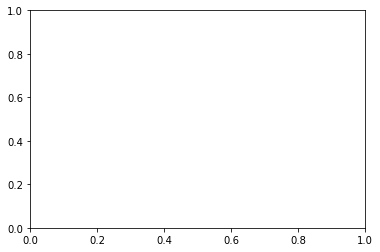

In [181]:
plt.plot(day_new,scaler.inverse_transform(t3[2000:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

In [ ]:
plt.plot(df3)